Note: 

- a lot of this could have been done cleaner with arrays, but it's still relatively fast 
- I played around with plotting different things and trying different formula at the beginning, then made the final plots at the end

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import astropy.constants as c
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interp1d
plt.rcParams["font.family"] = "serif"

pc_cgs = 3.0856776e18
yr_cgs = 31557600
au_cgs = (1*u.au).cgs.value
day_cgs = (1*u.day).cgs.value

In [5]:
def rho(r,rmin, t, tpeak, v, mdot_max):
    return 1./(4 * np.pi * r*r) * mdot_max * ((t - (r - rmin)/v)/(tpeak))**(-5/3) / v

In [6]:
# calculate Rstar from Mstar (using Tout et. al. 1996),
# in Tout paper -> Z = 0.02 (now not quite solar Z) and ZAMS
Z = 0.0134  # assume solar metallicity
log10_Z_02 = np.log10(Z / 0.02)

# Tout coefficients for calculating Rstar
Tout_theta = (1.71535900 + 0.62246212 * log10_Z_02 - 0.92557761 *
              log10_Z_02 ** 2 - 1.16996966 * log10_Z_02 ** 3 -
              0.30631491 *
              log10_Z_02 ** 4)
Tout_l = (6.59778800 - 0.42450044 * log10_Z_02 - 12.13339427 *
          log10_Z_02 ** 2 - 10.73509484 * log10_Z_02 ** 3 -
          2.51487077 * log10_Z_02 ** 4)
Tout_kpa = (10.08855000 - 7.11727086 * log10_Z_02 - 31.67119479 *
            log10_Z_02 ** 2 - 24.24848322 * log10_Z_02 ** 3 -
            5.33608972 * log10_Z_02 ** 4)
Tout_lbda = (1.01249500 + 0.32699690 * log10_Z_02 - 0.00923418 *
             log10_Z_02 ** 2 - 0.03876858 * log10_Z_02 ** 3 -
             0.00412750 * log10_Z_02 ** 4)
Tout_mu = (0.07490166 + 0.02410413 * log10_Z_02 + 0.07233664 *
           log10_Z_02 ** 2 + 0.03040467 * log10_Z_02 ** 3 +
           0.00197741 * log10_Z_02 ** 4)
Tout_nu = 0.01077422
Tout_eps = (3.08223400 + 0.94472050 * log10_Z_02 - 2.15200882 *
            log10_Z_02 ** 2 - 2.49219496 * log10_Z_02 ** 3 -
            0.63848738 * log10_Z_02 ** 4)
Tout_o = (17.84778000 - 7.45345690 * log10_Z_02 - 48.9606685 *
          log10_Z_02 ** 2 - 40.05386135 * log10_Z_02 ** 3 -
          9.09331816 * log10_Z_02 ** 4)
Tout_pi = (0.00022582 - 0.00186899 * log10_Z_02 + 0.00388783 *
           log10_Z_02 ** 2 + 0.00142402 * log10_Z_02 ** 3 -
           0.00007671 * log10_Z_02 ** 4)
# calculate Rstar in units of Rsolar
def Rstar(mstar):
    return ((Tout_theta * mstar ** 2.5 + Tout_l *
          mstar ** 6.5 +
          Tout_kpa * mstar ** 11 + Tout_lbda *
          mstar ** 19 +
          Tout_mu * mstar ** 19.5) /
         (Tout_nu + Tout_eps * mstar ** 2 + Tout_o *
          mstar ** 8.5 + mstar ** 18.5 + Tout_pi *
          mstar ** 19.5))

### Read in dmdt values from sims

- should be able to easily sub for other dmdt and time arrays here and use going forward

In [11]:
# read in energy and dmde

beta = '1.850'
e, d = np.genfromtxt('/Users/brennamockler/MOSFiT/mosfit/models/tde/data/4-3/'+beta+'.dat')


Mhbase = 1e6 * c.M_sun.cgs.value  # this is the bh mass assumed in the simulation fallback curves right now
G = c.G.cgs.value
# only convert dm/de --> dm/dt for mass that is bound to BH (e < 0)
ebound = e[e < 0]
dmdebound = d[e < 0]

if min(dmdebound) < 0:  # shouldn't happen, just a check

    print('beta, negative dmde bound:', beta, 
          dmdebound[dmdebound < 0])

# calculate de/dt, time and dm/dt arrays
# de/dt in log10(ergs/s), time in log10(seconds), dm/dt in log10(g/s)
dedt = (1.0 / 3.0) * (-2.0 * ebound) ** (5.0 / 2.0) / \
    (2.0 * np.pi * G * Mhbase)

# if files are in time & dmdt space, can start here
# saving in log space for now
simtime = np.log10((2.0 * np.pi * G * Mhbase) *
                      (-2.0 * ebound) ** (-3.0 / 2.0))  # log10(seconds)
simdmdt = np.log10(dmdebound * dedt) # log10(g/s)

dmdtinterp = interp1d(simtime, simdmdt)

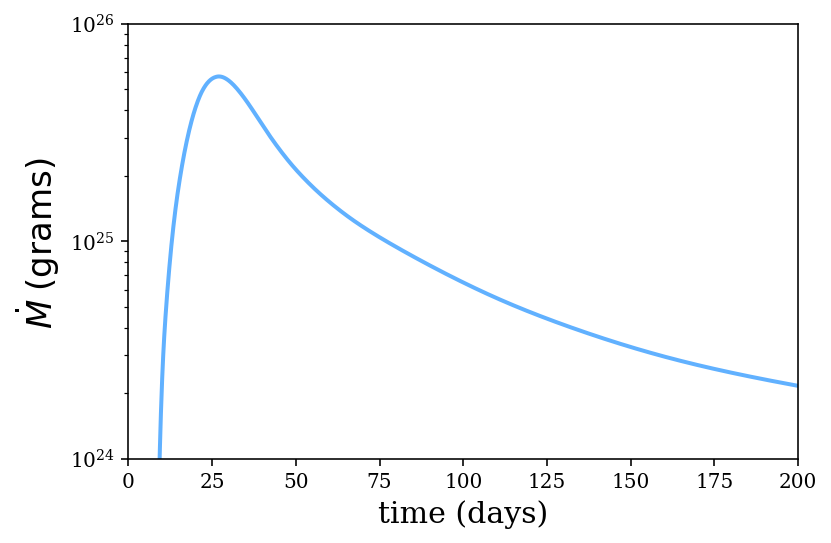

In [12]:
Mhbase = 1e6
Mh = 3e6

mstarbase = 1
mstar = 0.3

rstarbase = 1
rstar = Rstar(mstar)

# the simulation data goes to very late times, so just plot some for now
timesplot = np.linspace(10**simtime[0], 10**(simtime[0] + 2), num = 10*len(simtime))
dmdtplot = 10**dmdtinterp(np.log10(timesplot))

#times = 10**simtime # time in seconds from disruption
#dmdt = 10**simdmdt
dmdtplot = (dmdtplot * np.sqrt(Mhbase / Mh) *
        (mstar / mstarbase) ** 2.0 * (rstarbase / rstar) ** 1.5)
# tpeak ~ Mh^(1/2) * Mstar^(-1)
timesplot = (timesplot * np.sqrt(Mh / Mhbase) * (mstarbase / mstar) *
        (rstar / rstarbase) ** 1.5)

plt.plot(timesplot/day_cgs, dmdtplot, color = 'dodgerblue', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlim(0,200)
plt.ylim(1e24, 1e26)
plt.ylabel('$\dot{M} \; \\rm (grams)$ ', fontsize = 17)
plt.xlabel('time (days)', fontsize = 15)
plt.show()

tpeak =  27.13786063510936
tpeak, ff =  20.16660360758254


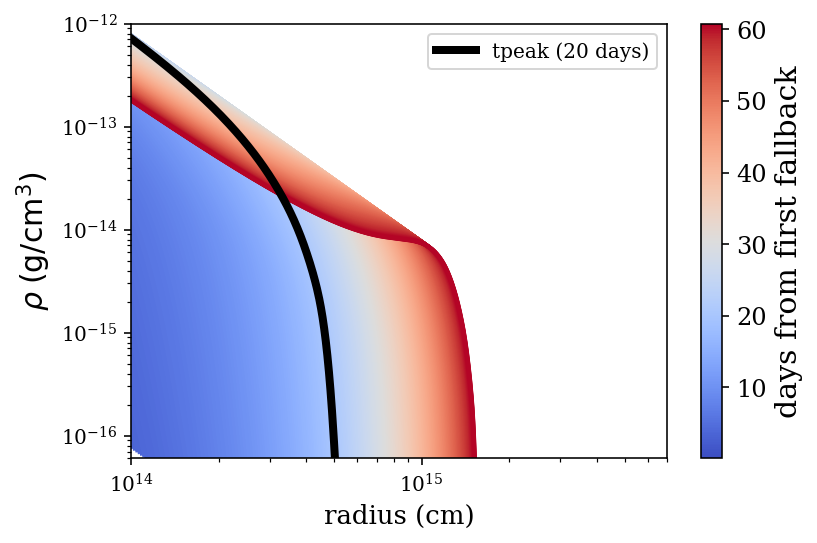

In [57]:
# using sim data

savefig = False  # save figure?

# parameters used in simulation
Mhbase = 1e6
mstarbase = 1
rstarbase = 1

# ------- parameters of disruption and wind outflow ---------------
# outflow velocity
vconst = 0.01*c.c.cgs.value 

# wind fraction  (going forward dmdt will refer to dmdt in wind, so dmdt_orig * frac_wind)
frac_wind = 0.5

# inner radius
rmin = 1e13 # cm

# black hole mass
Mh = 3e6

# mass of star
mstar = 0.3

# radius of star
rstar = Rstar(mstar)  # Rstar() function assumes ZAMS and solar metallicity, fine for testing

# ------------------------------------------------------------------------------



times = np.linspace(10**simtime[0], 10**(simtime[0] + 2), num = 10*len(simtime))
dmdt = 10**dmdtinterp(np.log10(times))


# scale time and dmdt for chosen bh mass and stellar properties


#dmdt = 10**simdmdt
dmdt = (dmdt * np.sqrt(Mhbase / Mh) *
        (mstar / mstarbase) ** 2.0 * (rstarbase / rstar) ** 1.5)

# times = 10**simtime # time in seconds from disruption
# tpeak ~ Mh^(1/2) * Mstar^(-1)
times = (times * np.sqrt(Mh / Mhbase) * (mstarbase / mstar) *
        (rstar / rstarbase) ** 1.5)

dmdt = frac_wind*dmdt    
dmdt = dmdt[:800] # 'times' is way too long
times = times[:800] # 'times' is way too long
dtimes = np.diff(times)

tpeak = times[np.argmax(dmdt)] #100 * daycgs
tpeak_ff = tpeak - times[0] # time from first fallback to peak (time = 0 at disruption for simulation data)

# make colormap
cmap = cm.coolwarm
vmax = max((times[1:]- times[0])/day_cgs)  # scale time from first fallback instead of from peak time
vmin = min((times[1:] - times[0])/day_cgs)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin,vmax=vmax))
sm.set_array([]) 
line_colors = [sm.to_rgba(t) for t in (times[1:] - times[0])/day_cgs] # this means order of line_colors matches 

# lists of lists -- each index will hold array corresponding to a time in time array
# not sure why I didn't use arrays, possibly was using list specific properties, idk
rarr_alltimes = []  
rhoarr_alltimes = []
dm_alltimes = []
timesused = []
indicesused = []
counter = 0
for ti, t in enumerate(times[1:]):  # could probably do this more cleverly with array manipulation, oh well
    
    #if np.log10(ti) < counter: continue
    # != 0 : continue
    
    counter+= 0.05
    timesused.append(t)
    indicesused.append(ti)
    dm = []
    
    timestemp = times[times<=t]
    # can increase sampling at later times at some point, reducing gap between 1e14 and 
    # where photosphere starts
    ##if ti>10:
    ##    extratimes = np.linspace(timestemp[0], timestemp[-1], 100)
    #    extradmdts = 10**dmdtinterp(np.log10(extratimes))
    #    newindices = [bis]
    #    times = list(times).extend(extratimes)
    
    # does sampling in t the way I'm doing it mess this up?? No, bc still adding up all
    # mass before that time, just sparse sampling in radius
    #for mi, m in enumerate(dmdt[times<=t][1:]):
    #    dm.append((m)*dtimes[mi])  # dtimes is array of dt values, dm is array of delta m (think of flow as discretized into packets of mass arriving at each time, with intervals between of dt)
    #dm = dm[::-1]  # flip list bc first mass that falls in will be at edge of wind, so largest radii from bh 
    
    dm = dmdt[times<=t][1:] * dtimes[times[1:]<=t] # does same thing as for loop, just cleaner
    dm = dm[::-1] # flip array bc first mass that falls in will be at edge of wind, so largest radii from bh 
    
    dm_alltimes.append(dm)
    rarr = (timestemp[-1] - timestemp[::-1])*vconst + rmin
    rarr_alltimes.append(rarr)
    drarr = np.diff(rarr)
    volarr = 4*np.pi*(rarr[1:]**2)*drarr # 4*pi*r^2 * dr

    rhoarr = np.array(dm)/volarr
    rhoarr_alltimes.append(rhoarr)
    color = line_colors[ti]
    linewidth = 2
    label = ''
    zorder = 1
    if t == tpeak:
        color = 'k'
        linewidth = 4
        label = 'tpeak ('+ '{:.0f}'.format(tpeak_ff/day_cgs) +' days)'
        zorder = 50
    plt.plot(rarr[1:], rhoarr, color = color, linewidth = linewidth, label = label,
             linestyle = '-',  zorder = zorder)

# code for plotting tpeak afterwards:

"""
dm = []
for mi, m in enumerate(dmdt[times<=tpeak][1:]):
    dm.append((m)*dtimes[mi])
#print(len(simdmdt[times<=t][1:]))
dm = dm[::-1]
timestemp = times[times<=tpeak]
rarr = (timestemp[-1] - timestemp[::-1])*vconst + rmin
drarr = np.diff(rarr)
volarr = 4*np.pi*(rarr[1:]**2)*drarr
#print(len(dm), len(timestemp), len(drarr), len(volarr))
rhoarr = np.array(dm)/volarr
color = 'k'
linewidth = 3
label = 'tpeak ('+ '{:.0f}'.format(tpeak_ff/day_cgs) +' days)'
zorder = 50
plt.plot(rarr[1:], rhoarr, color = color, linewidth = linewidth, label = label, linestyle = '-')

#plt.plot(rarr[1:], 1e-11*(radiusarr[-1]/radiusarr[-1][0])**(-2.), color = 'red')
rarr = np.logspace(13, np.log10(1e16))
for rho in np.logspace(-18,-3, num = 15):
    plt.plot(rarr, rho*(rarr/rarr[0])**(-2), color = 'k', linestyle = '--', linewidth = 0.8)
    
"""
print('tpeak = ', tpeak/day_cgs)
print('tpeak, ff = ', tpeak_ff/day_cgs)
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 
plt.legend(loc = 1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e14, 7e15)
plt.ylim(6e-17, 1e-12)
plt.ylabel('$\\rho \\; \\rm (g/cm^3) $', fontsize = 15)
plt.xlabel('radius (cm)', fontsize = 13)


if savefig:
    plt.savefig('plots/rho_vs_radius_Mh3e6_mstar1_Me0.5Mdot_vconst0.01c_rmin1e14_1_dashed.pdf', bbox_inches='tight', transparent = True)
plt.show()

## try plotting diffusion timescale and optical depth

In [58]:
kappa = 0.32 # cm^2/g (electron scattering)
def tau_es(Menv, rin, rout):
    return kappa*Menv/(4 * np.pi * rin * rout)

# more accurate calculation (with integral) used later

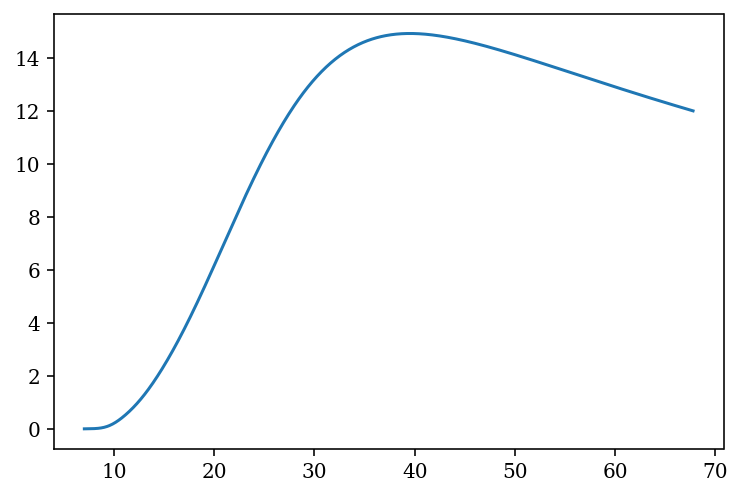

In [59]:
tauarr = []
counter = 0
for ri, rarr in enumerate(rarr_alltimes):
    Menv = np.sum(dm_alltimes[ri])
    #print(ri)
    rin = 1e14
    rout = rarr[-1]
    #print(Menv, rout)
    tauarr.append(tau_es(Menv, rin, rout))
    #counter=+1
    #plt.scatter(t/daycgs, tauarr[-1], marker = 'o', color = line_colors[ti])
plt.plot(np.array(timesused)/day_cgs, tauarr)

###  plot the diffusion time through the envelope as a fn of time

From Roth 2016:
- note that density profile goes as r^-2

$t_{\rm diff} \sim \bar{r}^2 \kappa \bar{\rho}/c$ where $\bar{\rho}$ is an appropriately weighted
envelope density and $\bar{r}$ a characteristic envelope length
scale. 

Taking $\bar{\rho} = \rho(\bar{r})$ gives $t_{\rm diff} \sim 10 M_{\rm e,0.5}r_{\rm i,14}$ days

In [60]:
# both of these estimates for diffusion timescale are from Roth+2016

# bad approximation
def tdiff_approx0(Menv, ri):
    # Menv and ri in cgs
    # returns tdiff in days
    return 10*(Menv/(0.5*c.M_sun.cgs))*(1e14/ri)

# slightly better approx
kappa = 0.32 # cm^2/g (electron scattering)
def tdiff_approx1(rbar, rhobar, kappa):
    # rbar and rhobar are characteristic length scale and density for envelope
    return rbar*rbar*kappa*rhobar/c.c.cgs.value

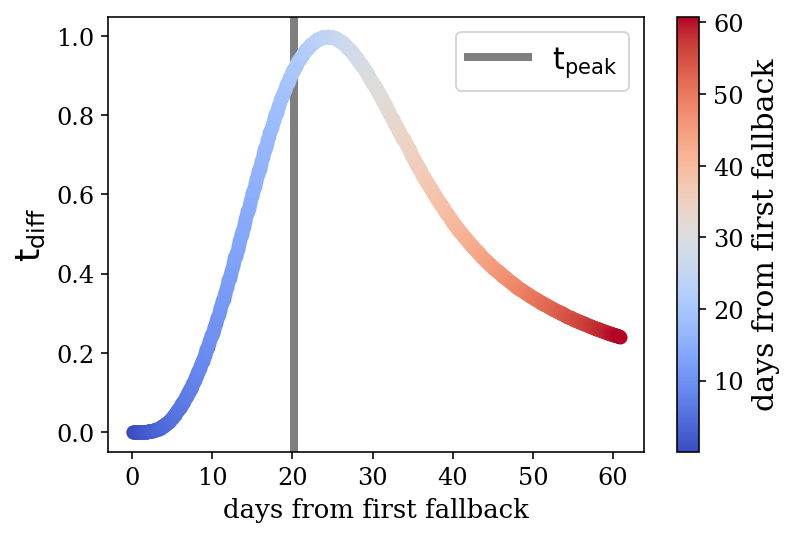

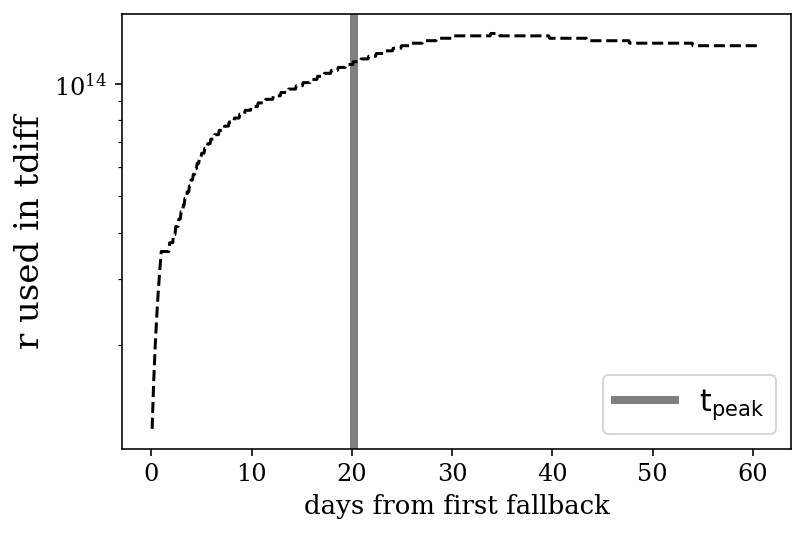

"\ntauescut = 10\ntdiffarr = []\nrphotarr= []\nfor ri, rho in enumerate(rhoarr_alltimes):\n    cut = np.array(tauarr[ri]) >= tauescut\n    rhoenv = rho[cut]\n    rarr = rarr_alltimes[ri][1:][cut]\n    if not len(rarr):\n        rarr = [0]\n        rhoenv = [rho[0]]\n    rphotarr.append(rarr[0])\n    rhobar = rhoenv[0]\n    rbar = rarr[0]\n    tdiffarr.append(tdiff_approx1(rbar, rhobar, kappa)/daycgs)\n    plt.scatter((timesused[ri]-times[0])/daycgs, tdiffarr[-1], marker = 'o', color = line_colors[indicesused[ri]], zorder = 50)\n    \nplt.plot((np.array(timesused) - times[0])/daycgs, tdiffarr, color = 'k', linestyle = '--', zorder = 10)\n\nplt.axvline(tpeak_ff/daycgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')\ncbar = plt.colorbar(sm)\nplt.setp(cbar.ax.get_yticklabels(), fontsize = 12)\ncbar.set_label('days from first fallback', fontsize = 15) \n\nplt.legend(loc = 'best', fontsize = 15)\nplt.ylabel('$\\rm t_{\\rm diff}$', fontsize = 17)\nplt.xlabel('days fr

In [61]:
# in Nathan's 2016 paper, rout is such that density is 1/100 of rin. (rout = 10rin, rho ~ r^-2) 
# Use that for now as proxy for where rout is
# what to use for rhobar? maybe the same vlaue? (rho(rbar))
rhofrac = 1e-2 #2.7**(-2)  # when density drops to rho_rin*rhofrac, define that radius as outer boundary
# in Roth 2017, outer continuum radius is set to 2.7e14cm, inner radius to 1e14cm, for rho ~ r^-2
# this corresponds to a density decrease of 2.7^-2
kappa = 0.34 # more recent value from Nathan's 2017 paper
tdiffarr = []
rbar_all = [] #arr= []
for ri, rho in enumerate(rhoarr_alltimes):
    cut = rho > rhofrac*rho[0]  # calculating diffusion timescale at 'characteristic' radius/density
    rhoenv = rho[cut]
    rarr = rarr_alltimes[ri][1:][cut]
    rhobar = rhoenv[-1]
    rbar = rarr[-1]
    rbar_all.append(rarr[-1])
    tdiffarr.append(tdiff_approx1(rbar, rhobar, kappa)/day_cgs)
    plt.scatter((timesused[ri]-times[0])/day_cgs, tdiffarr[-1], marker = 'o', color = line_colors[indicesused[ri]], zorder = 50)
    
plt.plot((np.array(timesused) - times[0])/day_cgs, tdiffarr, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/day_cgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\rm t_{\\rm diff}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)

plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)

plt.show()

plt.plot((np.array(timesused) - times[0])/day_cgs, rbar_all, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/day_cgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('r used in tdiff', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)
plt.yscale('log')
plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)

plt.show()

# now instead calculate tdiff using rphot = radius where tau_es (optical depth to electron scattering) = 10

"""
tauescut = 10
tdiffarr = []
rphotarr= []
for ri, rho in enumerate(rhoarr_alltimes):
    cut = np.array(tauarr[ri]) >= tauescut
    rhoenv = rho[cut]
    rarr = rarr_alltimes[ri][1:][cut]
    if not len(rarr):
        rarr = [0]
        rhoenv = [rho[0]]
    rphotarr.append(rarr[0])
    rhobar = rhoenv[0]
    rbar = rarr[0]
    tdiffarr.append(tdiff_approx1(rbar, rhobar, kappa)/daycgs)
    plt.scatter((timesused[ri]-times[0])/daycgs, tdiffarr[-1], marker = 'o', color = line_colors[indicesused[ri]], zorder = 50)
    
plt.plot((np.array(timesused) - times[0])/daycgs, tdiffarr, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/daycgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\rm t_{\\rm diff}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)

plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)

plt.show()

plt.plot((np.array(timesused) - times[0])/daycgs, rphotarr, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/daycgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\rm R_{\\rm phot}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)
plt.yscale('log')
plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)

plt.show()

"""


## calculate optical depth

$\tau_{\rm es} = \int{\kappa \rho dr}$

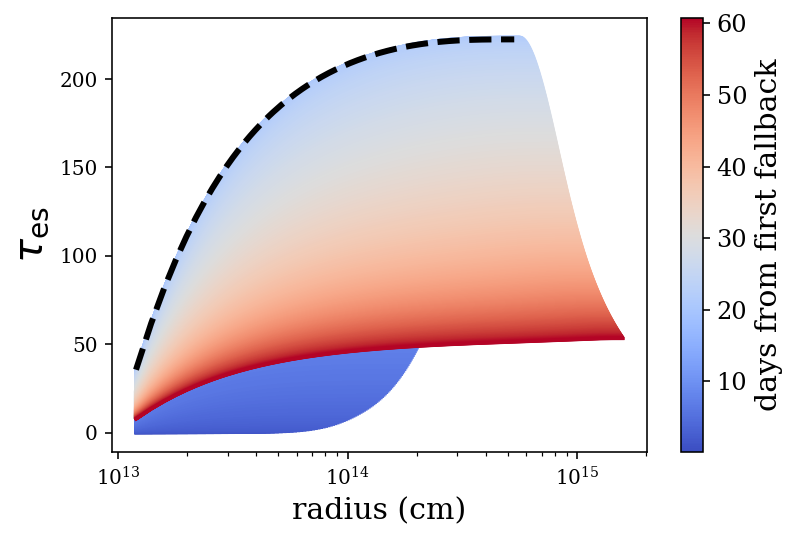

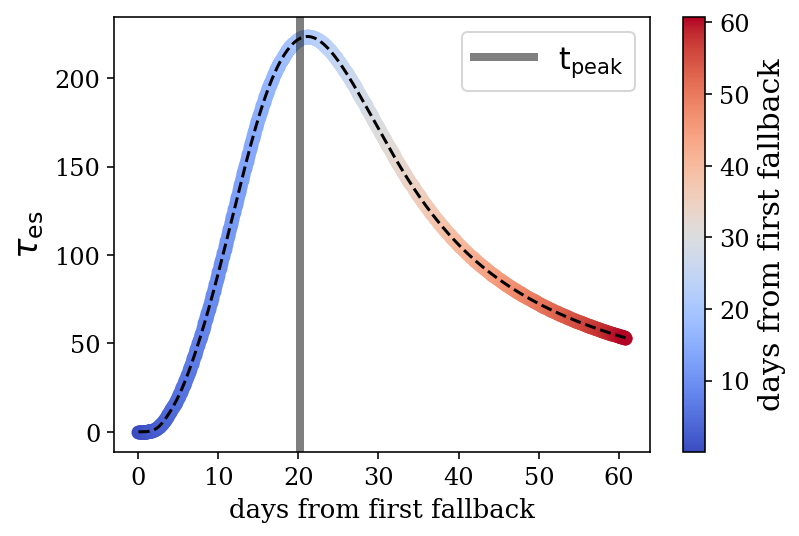

In [35]:
# this is just a better calculation of the optical depth than in equation above
kappa = 0.34 # cm^2/g 
opticaldepth = []
for ri, rarr in enumerate(rarr_alltimes):
    drarr = np.diff(rarr)
    integral = kappa*rhoarr_alltimes[ri]*drarr
    integral = [np.sum(integral[:1+i]) for i in range(len(integral))]
    opticaldepth.append(integral)

for ri, rarr in enumerate(rarr_alltimes):
    plt.plot(rarr[1:], opticaldepth[ri], color = line_colors[indicesused[ri]])
    
    
    
# plotting tpeak:
dm = []
for mi, m in enumerate(dmdt[times<=tpeak][1:]):
    dm.append((m)*dtimes[mi])
#print(len(simdmdt[times<=t][1:]))
dm = dm[::-1]
timestemp = times[times<=tpeak]
rarr = (timestemp[-1] - timestemp[::-1])*vconst + rmin
drarr = np.diff(rarr)
volarr = 4*np.pi*(rarr[1:]**2)*drarr
#print(len(dm), len(timestemp), len(drarr), len(volarr))
rhoarr = np.array(dm)/volarr
color = 'k'
linewidth = 3
label = 'tpeak ('+ '{:.0f}'.format(tpeak_ff/day_cgs) +' days)'
zorder = 50
integral = kappa*rhoarr*drarr
integral = [np.sum(integral[:1+i]) for i in range(len(integral))]
plt.plot(rarr[1:], integral, color = color, linewidth = linewidth, label = label, linestyle = '--')
    
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.xscale('log')

plt.ylabel('$\\tau_{\\rm es}$', fontsize = 20)
plt.xlabel('radius (cm)', fontsize = 15)
plt.show()

#colorsused =  [line_colors[index] for index in indicesused] 
for opi, op in enumerate(opticaldepth):
    plt.scatter((timesused[opi]-times[0])/day_cgs, op[-1], color = line_colors[indicesused[opi]], marker = 'o')
plt.plot((timesused-times[0])/day_cgs, [op[-1] for op in opticaldepth], color = 'k', linestyle = '--')

plt.axvline(tpeak_ff/day_cgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')

cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\tau_{\\rm es}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)

plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)
plt.show()

## calculate Rphot

- integrate optical depth backward to get rphot:
$\tau_{\rm es} = \int_{R_{\rm ej}}^{r_{\rm min}}{\kappa \rho dr}$

- determine photosphere as radius where $\tau_{\rm es}$ = some value (using 2/3 here)


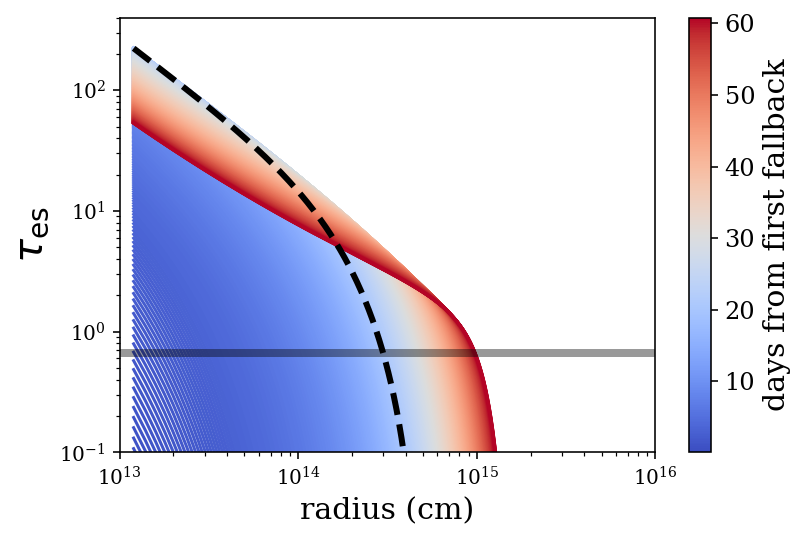

In [49]:
# integrate BACKWARD to get Rphot
# - determines where we see photosphere

kappa = 0.34 # cm^2/g 
opticaldepth = []
for ri, rarr in enumerate(rarr_alltimes):
    drarr = np.diff(rarr)
    integral = kappa*rhoarr_alltimes[ri]*drarr
    # rn integral holds integrand at each radius r, with min radius at i = 0
    integral = integral[::-1] # flip it, so value at min radius is at i = -1
    integral = [np.sum(integral[:1+i]) for i in range(len(integral))]
    opticaldepth.append(integral)
    # optical depth holds optical depth as fn of radius,
    # first value corresponds to outer radius, last value corresponds to inner radius
    

for ri, rarr in enumerate(rarr_alltimes):
    plt.plot(rarr[1:][::-1], opticaldepth[ri], color = line_colors[indicesused[ri]])
    
    
    
# plotting tpeak:
dm = []
for mi, m in enumerate(dmdt[times<=tpeak][1:]):
    dm.append((m)*dtimes[mi])
#print(len(simdmdt[times<=t][1:]))
dm = dm[::-1]
timestemp = times[times<=tpeak]
rarr = (timestemp[-1] - timestemp[::-1])*vconst + rmin
drarr = np.diff(rarr)
volarr = 4*np.pi*(rarr[1:]**2)*drarr
#print(len(dm), len(timestemp), len(drarr), len(volarr))
rhoarr = np.array(dm)/volarr
color = 'k'
linewidth = 3
label = 'tpeak ('+ '{:.0f}'.format(tpeak_ff/day_cgs) +' days)'
zorder = 50
integral = kappa*rhoarr*drarr
integral = integral[::-1]
integral = [np.sum(integral[:1+i]) for i in range(len(integral))]
plt.plot(rarr[1:][::-1], integral, color = color, linewidth = linewidth, label = label, linestyle = '--')
    
plt.axhline(2/3, color = 'k', alpha = 0.4, linewidth = 4)
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 4e2)
plt.xlim(1e13, 1e16)

plt.ylabel('$\\tau_{\\rm es}$', fontsize = 20)
plt.xlabel('radius (cm)', fontsize = 15)
plt.show()

### calculate $\rm t_{\rm diff}$ by integrating out to $\tau_{\rm es} = 2/3$ 


$ t_{\rm diff} = \kappa \rho R_{\rm ej}^2/c$ (or $ t_{\rm diff} = \kappa \rho R_{\rm phot}^2/c$ )

but $\rho$ is a function of $r$ so use:

$ t_{\rm diff} = \kappa/c \int_{r_{\rm min}}^{r(\tau_{es} = 2/3)}{ \rho(r) r dr}$

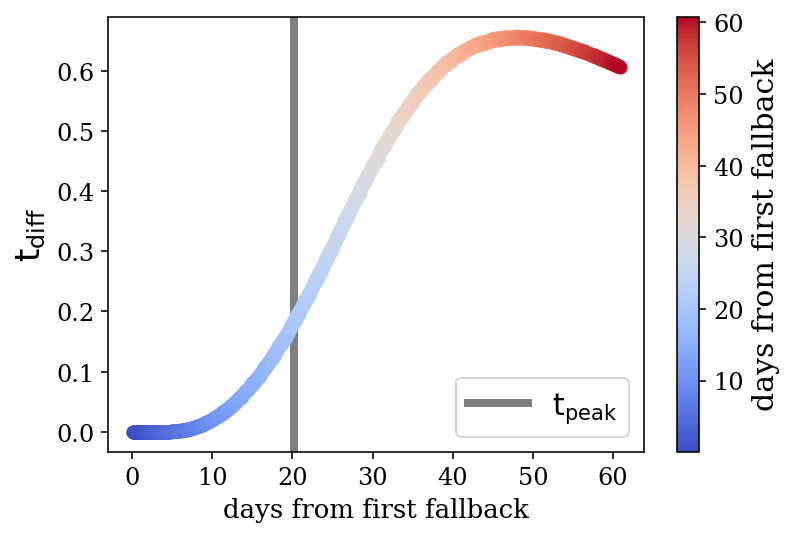

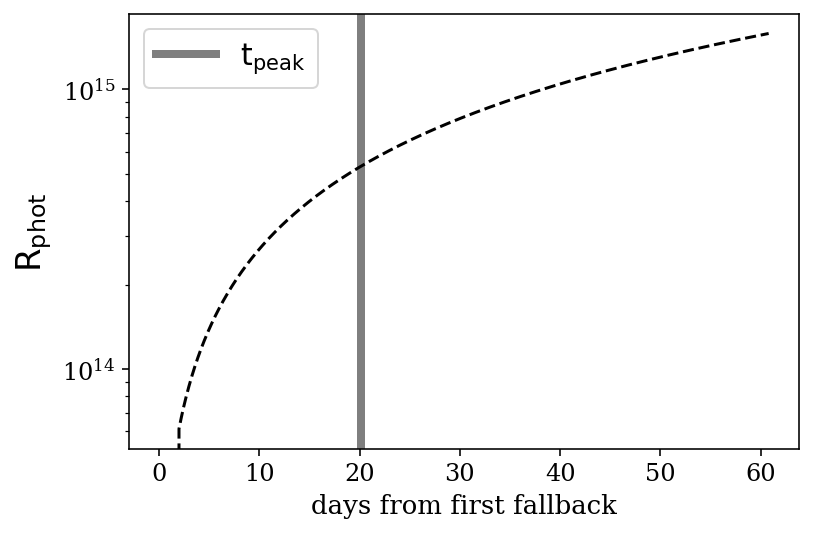

In [64]:
# now instead calculate tdiff using rphot = radius where tau_es (optical depth to electron scattering) = 2/3
save = False

tauescut = 2./3.
tdiffarr = []
rphotarr= []
for ri, rho in enumerate(rhoarr_alltimes):
    od_flipped = opticaldepth[ri][::-1] # now value at i = 0 is optical depth at rmin, integrated outward in
    cut = np.array(opticaldepth[ri]) >= tauescut  # cut out region outside photosphere (photosphere radius defined by tau cut)
    #len(cut), len(rho), len
    rhoenv = rho[cut]
    drarr = np.diff(rarr_alltimes[ri])
    rarr = rarr_alltimes[ri][1:][cut]
    drarr = drarr[cut]
    rarr = rarr[1:]
    #print(rarr)
    if not len(rarr):
        rarr = [0]
        drarr = [0]
        rhoenv = [rho[0]]
    rphotarr.append(rarr[-1])
    rhobar = rhoenv[-1]
    #rbar = rarr[0]
    rout = rarr[-1]
    # integral(kappa/c rho * r *dr) ~ kappa/c rho * r^2
    tdiff_integrand = [kappa/c.c.cgs.value * rhoenv[radi] * radius* drarr[radi] for radi, radius in enumerate(rarr)]
    tdiff = np.sum(tdiff_integrand)
    
    #dm_alltimes
    #print(rbar, rhobar, kappa)
    #tdiffarr.append(tdiff_approx1(rbar, rhobar, kappa)/day_cgs)
    #print(tdiff/day_cgs)
    tdiffarr.append(tdiff/day_cgs)
    plt.scatter((timesused[ri]-times[0])/day_cgs, tdiffarr[-1], marker = 'o', color = line_colors[indicesused[ri]], zorder = 50)
    
plt.plot((np.array(timesused) - times[0])/day_cgs, tdiffarr, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/day_cgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
cbar = plt.colorbar(sm)
plt.setp(cbar.ax.get_yticklabels(), fontsize = 12)
cbar.set_label('days from first fallback', fontsize = 15) 

plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\rm t_{\\rm diff}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)

plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)
if save:
    plt.savefig('plots/tdiff_vs_time_Mh3e6_mstar1_Me0.5Mdot_vconst0.01c_rmin1e13.pdf', bbox_inches='tight', transparent = True)

plt.show()

plt.plot((np.array(timesused) - times[0])/day_cgs, rphotarr, color = 'k', linestyle = '--', zorder = 10)

plt.axvline(tpeak_ff/day_cgs, color = 'k', alpha = 0.5, linewidth = 4, label = '$\\rm t_{\\rm peak}$')
plt.legend(loc = 'best', fontsize = 15)
plt.ylabel('$\\rm R_{\\rm phot}$', fontsize = 17)
plt.xlabel('days from first fallback', fontsize = 13)
plt.yscale('log')
plt.setp(plt.gca().get_xticklabels(), fontsize = 12)
plt.setp(plt.gca().get_yticklabels(), fontsize = 12)

plt.show()

In [71]:
opticaldepth[-1][0]

2.1028596625487255e-07